当前工作目录: /Users/mastin/project_folder


/var/folders/ss/1k6s1myj40l0pz1pm9k7ztbw0000gn/T/ipykernel_58499/146065603.py:164: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[selected_features] = df[selected_features].fillna(method='ffill').fillna(method='bfill')
/opt/anaconda3/envs/tf_m3_new/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
python(63475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
python(63476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
14:12:58 - cmdstanpy - 

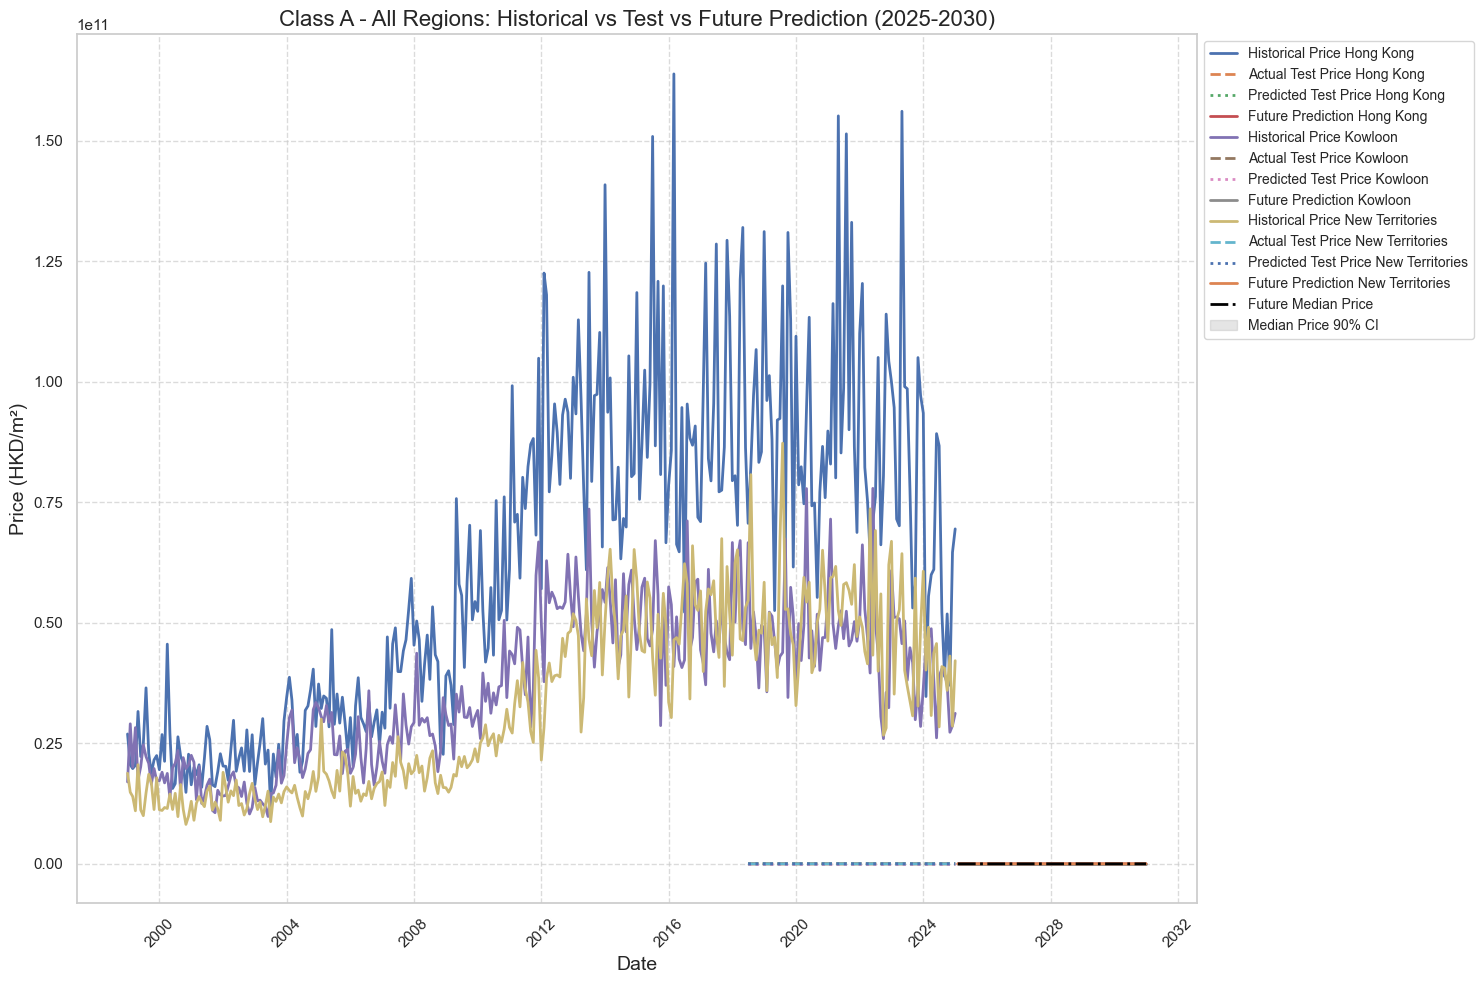

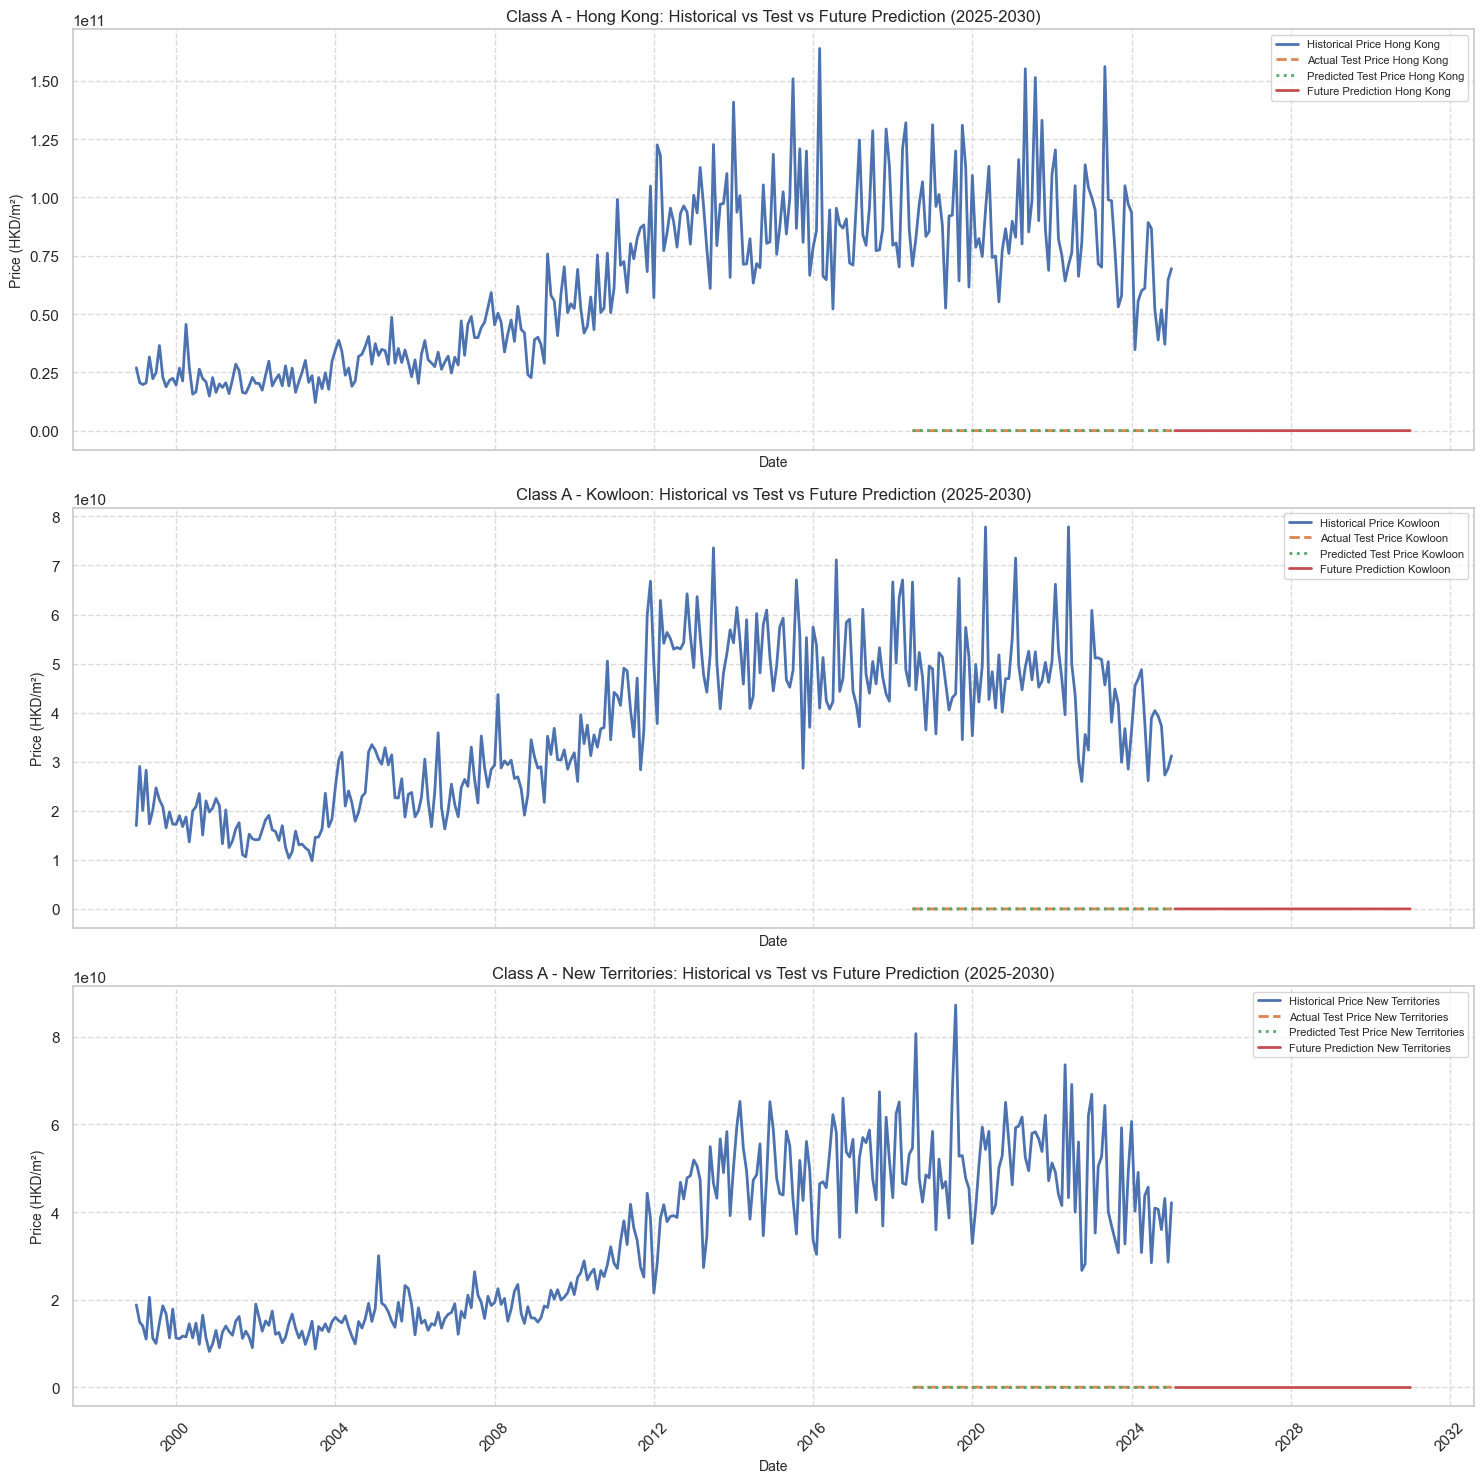

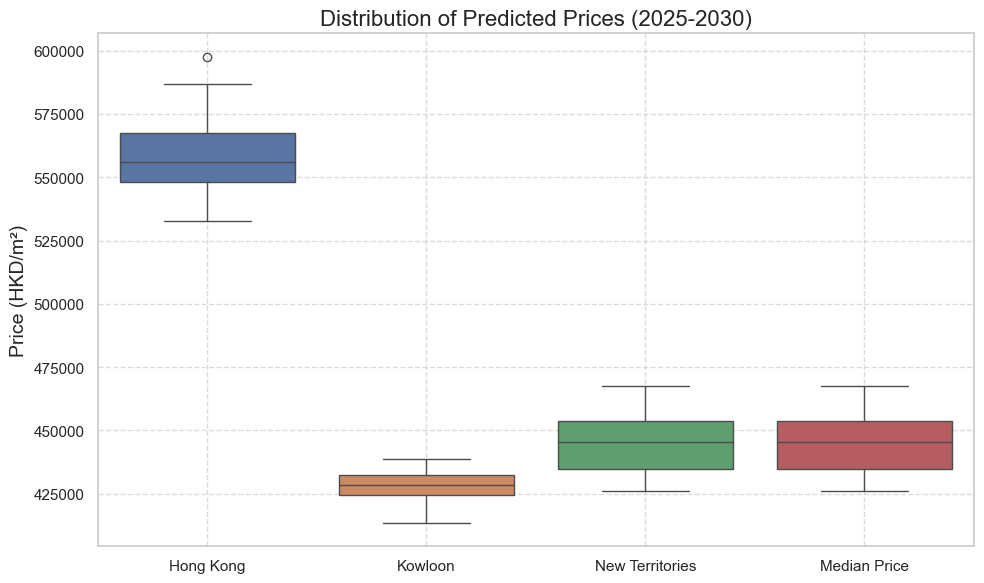

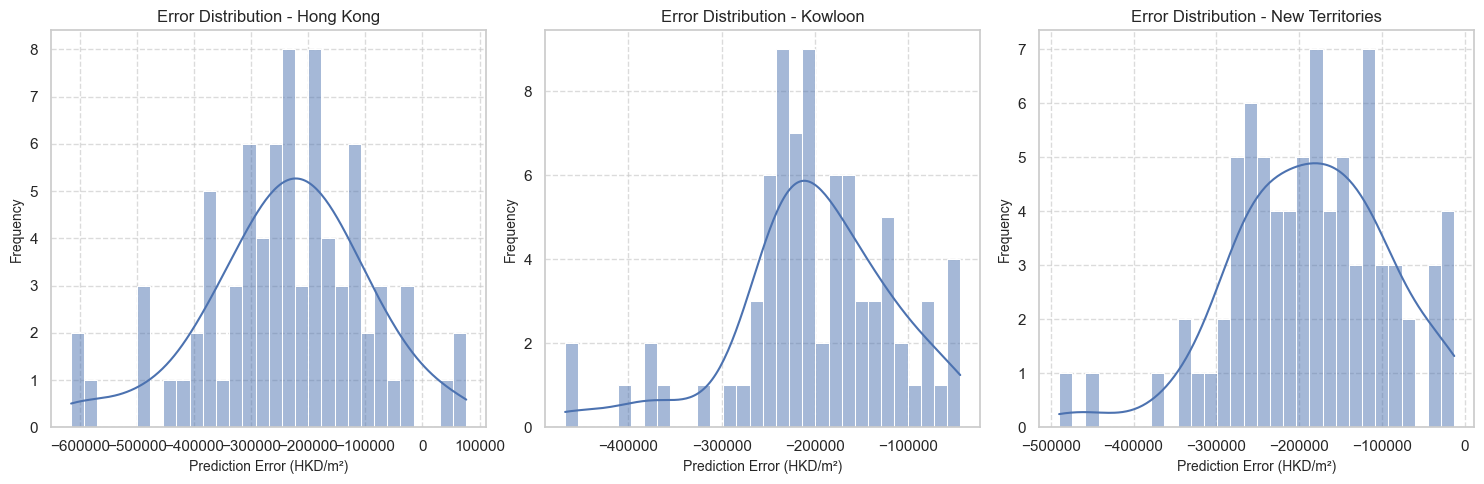

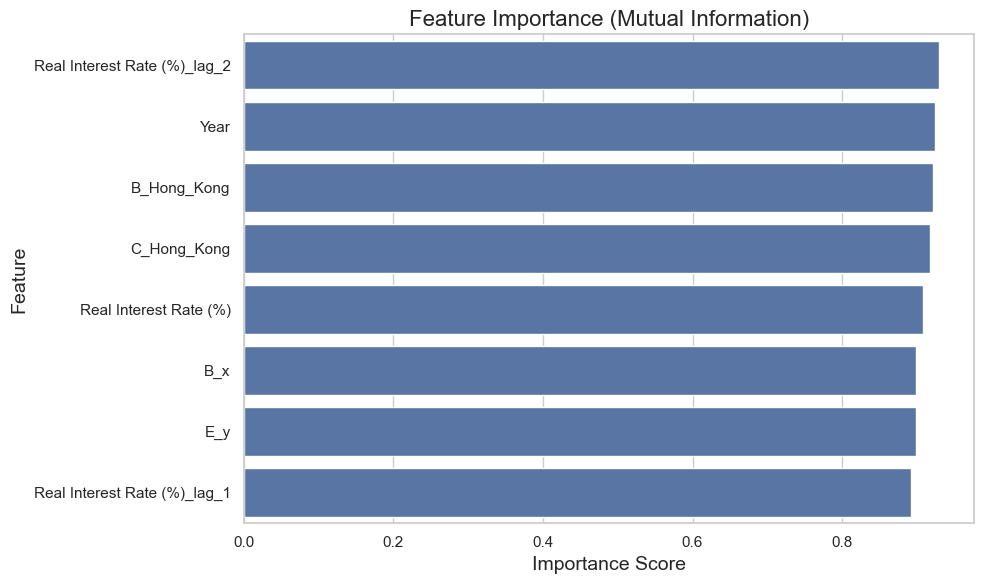

         Date  Predicted Price HK  Predicted Price KL  Predicted Price NT  \
0  2025-02-01       532561.350905       426159.113423       434893.378220   
1  2025-03-01       565418.865309       430434.917771       430781.672936   
2  2025-04-01       536306.291856       433032.176439       427816.849758   
3  2025-05-01       538126.340369       424397.165215       425987.314350   
4  2025-06-01       542571.270602       420073.178968       432046.967684   
5  2025-07-01       543815.617968       425250.993909       431366.387656   
6  2025-08-01       544099.021229       432059.096459       429873.575061   
7  2025-09-01       543469.610806       417446.457108       431466.168127   
8  2025-10-01       549590.587855       416385.316288       427946.045907   
9  2025-11-01       550793.586610       431227.806268       437505.791195   
10 2025-12-01       533471.058672       430237.687108       432593.014050   
11 2026-01-01       547145.376621       428335.590343       433610.921774   

In [80]:
import pandas as pd
import numpy as np
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging
from tqdm import tqdm
import gc
import traceback
from joblib import Parallel, delayed

# 设置工作目录
BASE_DIR = '/Users/mastin/project_folder'
os.makedirs(BASE_DIR, exist_ok=True)
os.chdir(BASE_DIR)
print("当前工作目录:", os.getcwd())

# 配置日志
logging.basicConfig(filename=os.path.join(BASE_DIR, 'output.log'), level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 检查数据文件是否存在
def check_data_update(file_paths):
    for file_path in file_paths:
        if not os.path.exists(file_path):
            logger.error(f"Data file {file_path} not found.")
            raise FileNotFoundError(f"Data file {file_path} not found.")
    return True

# 数据预处理
def preprocess_data(file_paths):
    try:
        logger.info("Loading data files...")
        df_rents_prices = pd.read_csv(file_paths[0])
        df_yields = pd.read_csv(file_paths[1])
        df_sales = pd.read_csv(file_paths[2])
        df_population = pd.read_csv(file_paths[3])
        df_rental_prices = pd.read_csv(file_paths[4])
        df_rental_indices = pd.read_csv(file_paths[5])
        df_economic = pd.read_csv(file_paths[6])

        # 打印每个数据文件的列名和前几行数据以调试
        logger.info(f"Columns in df_rents_prices: {df_rents_prices.columns.tolist()}")
        logger.info(f"First 5 rows of df_rents_prices:\n{df_rents_prices.head().to_string()}")
        logger.info(f"Columns in df_yields: {df_yields.columns.tolist()}")
        logger.info(f"First 5 rows of df_yields:\n{df_yields.head().to_string()}")
        logger.info(f"Columns in df_sales: {df_sales.columns.tolist()}")
        logger.info(f"First 5 rows of df_sales:\n{df_sales.head().to_string()}")
        logger.info(f"Columns in df_population: {df_population.columns.tolist()}")
        logger.info(f"First 5 rows of df_population:\n{df_population.head().to_string()}")
        logger.info(f"Columns in df_rental_prices: {df_rental_prices.columns.tolist()}")
        logger.info(f"First 5 rows of df_rental_prices:\n{df_rental_prices.head().to_string()}")
        logger.info(f"Columns in df_rental_indices: {df_rental_indices.columns.tolist()}")
        logger.info(f"First 5 rows of df_rental_indices:\n{df_rental_indices.head().to_string()}")
        logger.info(f"Columns in df_economic: {df_economic.columns.tolist()}")
        logger.info(f"First 5 rows of df_economic:\n{df_economic.head().to_string()}")

        # 清理 Year 列并转换为 int64
        df_rental_prices['Year'] = df_rental_prices['Year'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype('int64')
        df_rental_indices['Year'] = df_rental_indices['Year'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype('int64')

        df_rents_prices['Year'] = df_rents_prices['Year'].astype('int64')
        df_yields['Year'] = df_yields['Year'].astype('int64')
        df_sales['Year'] = df_sales['Year'].astype('int64')
        df_population['Year'] = df_population['Year'].astype('int64')
        df_economic['Year'] = df_economic['Year'].astype('int64')

        df_rents_prices['Date'] = pd.to_datetime(df_rents_prices[['Year', 'Month']].assign(day=1))
        df_yields['Date'] = pd.to_datetime(df_yields[['Year', 'Month']].assign(day=1))
        df_sales['Date'] = pd.to_datetime(df_sales[['Year', 'Month']].assign(day=1))

        logger.info("Merging datasets...")
        df = df_rents_prices.merge(df_yields, on=['Year', 'Month', 'Date'], how='left')\
                            .merge(df_sales, on=['Year', 'Month', 'Date'], how='left')\
                            .merge(df_rental_prices, on=['Year'], how='left')\
                            .merge(df_rental_indices, on=['Year'], how='left')\
                            .merge(df_economic, on=['Year'], how='left')\
                            .merge(df_population, on=['Year'], how='left')

        if df.empty:
            raise ValueError("Merged DataFrame is empty.")

        # 打印合并后的 DataFrame 列名和前几行数据以调试
        logger.info(f"Columns in merged DataFrame: {df.columns.tolist()}")
        logger.info(f"First 5 rows of merged DataFrame:\n{df.head().to_string()}")

        df = df.dropna(subset=['Date'])
        
        # 动态获取价格列名
        target_cols = [col for col in df.columns if 'Price' in col and any(region in col for region in ['Hong_Kong', 'Kowloon', 'New_Territories'])]
        if len(target_cols) != 3:
            raise ValueError(f"Expected 3 price columns, but found {len(target_cols)}: {target_cols}")
        
        # 打印目标列数据以调试
        logger.info(f"Target columns: {target_cols}")
        for col in target_cols:
            logger.info(f"Data in {col} (first 5 rows): {df[col].head().to_list()}")
            logger.info(f"Min value in {col}: {df[col].min()}, Max value in {col}: {df[col].max()}")
            if df[col].max() == 0 and df[col].min() == 0:
                raise ValueError(f"Target column {col} contains all zeros. Please check the data file.")
        
        # 特征工程（利用所有数据）
        feature_cols = [col for col in df.columns if col not in ['Date'] + target_cols and df[col].dtype in [np.float64, np.int64]]
        selected_features = feature_cols.copy()
        
        # 添加时间序列特征（lag 特征）
        for col in target_cols:
            for lag in range(1, 3):  # 增加 lag 范围
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            selected_features.extend([f'{col}_lag_{lag}' for lag in range(1, 3)])

        # 动态检测 GDP、利率和人口列
        gdp_column = None
        interest_column = None
        population_column = None

        for col in df.columns:
            if 'GDP Growth Rate' in col:
                gdp_column = col
            if 'Real Interest Rate' in col:
                interest_column = col
            if 'Population' in col:
                population_column = col

        # 添加交互特征
        if gdp_column and population_column:
            df['GDP_Population'] = df[gdp_column] * df[population_column]
            selected_features.append('GDP_Population')
        else:
            logger.warning(f"GDP or Population column not found. Skipping GDP_Population feature.")

        if interest_column and 'A' in df.columns:
            df['Interest_Rental_Ratio'] = df[interest_column] / (df['A'] + 1e-6)
            selected_features.append('Interest_Rental_Ratio')
        else:
            logger.warning(f"Interest Rate or Rental Index column not found. Skipping Interest_Rental_Ratio feature.")

        # 添加租金指数和经济指标的 lag 特征
        for col in ['A', 'B', 'C', 'D', 'E', 'A_Hong_Kong', 'A_Kowloon', 'A_New_Territories']:
            if col in df.columns:
                for lag in range(1, 3):
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
                selected_features.extend([f'{col}_lag_{lag}' for lag in range(1, 3)])

        if gdp_column:
            for lag in range(1, 3):
                df[f'{gdp_column}_lag_{lag}'] = df[gdp_column].shift(lag)
            selected_features.extend([f'{gdp_column}_lag_{lag}' for lag in range(1, 3)])

        if interest_column:
            for lag in range(1, 3):
                df[f'{interest_column}_lag_{lag}'] = df[interest_column].shift(lag)
            selected_features.extend([f'{interest_column}_lag_{lag}' for lag in range(1, 3)])

        # 填充缺失值（使用前向填充）
        df[selected_features] = df[selected_features].fillna(method='ffill').fillna(method='bfill')
        
        # 再次检查并填充 NaN 值（以防万一）
        if df[selected_features].isna().any().any():
            logger.warning("NaN values found after initial fill. Filling with column means...")
            df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
        
        # 移除完全为 NaN 的列
        selected_features = [col for col in selected_features if not df[col].isna().all()]
        if not selected_features:
            raise ValueError("No valid features after removing columns with all NaN values.")
        
        # 打印 selected_features 的长度
        logger.info(f"Number of selected features before feature selection: {len(selected_features)}")
        
        # 异常值处理：使用 Z 分数方法
        for col in target_cols + selected_features:
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            df[col] = df[col].where(z_scores < 3, df[col].mean())
        
        # 准备训练数据
        X = df[selected_features].values
        y = df[target_cols].values
        
        # 打印 y 的值以调试
        logger.info(f"Target values (y) before scaling: {y[:5]}")
        logger.info(f"Target values (y) min: {y.min()}, max: {y.max()}")
        
        # 标准化特征（先不适配，等特征选择后再适配）
        feature_scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = feature_scaler.fit_transform(X)
        
        # 标准化目标变量（使用 StandardScaler 替代 MinMaxScaler）
        price_scaler = StandardScaler()
        y_scaled = price_scaler.fit_transform(y)
        
        # 打印 price_scaler 的参数以调试
        logger.info(f"Price scaler mean_: {price_scaler.mean_}")
        logger.info(f"Price scaler scale_: {price_scaler.scale_}")
        
        # 分割训练和测试数据
        train_size = int(len(X_scaled) * 0.75)
        X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
        y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
        
        # 打印数据形状以调试
        logger.info(f"X_train shape: {X_train.shape}")
        logger.info(f"X_test shape: {X_test.shape}")
        logger.info(f"y_train shape: {y_train.shape}")
        logger.info(f"y_test shape: {y_test.shape}")
        
        # 打印 y_test 的值以调试
        logger.info(f"y_test before inverse transform: {y_test[:5]}")
        
        # 再次检查 X_train 和 X_test 中的 NaN 值
        if np.any(np.isnan(X_train)):
            logger.warning("NaN values found in X_train. Filling with column means...")
            X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train, axis=0))
        if np.any(np.isnan(X_test)):
            logger.warning("NaN values found in X_test. Filling with column means...")
            X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test, axis=0))
        
        # 特征选择：使用互信息法选择重要特征
        logger.info("Performing feature selection with mutual information...")
        mi_scores = mutual_info_regression(X_train, y_train[:, 0])
        important_features_idx = np.argsort(mi_scores)[-8:]  # 选择前 8 个重要特征
        selected_features = [selected_features[i] for i in important_features_idx]  # 确保 selected_features 只包含 8 个特征
        logger.info(f"Selected features after feature selection: {selected_features}")
        logger.info(f"Number of selected features after feature selection: {len(selected_features)}")
        
        # 保存特征重要性分数
        feature_importance = pd.DataFrame({
            'Feature': [selected_features[i] for i in range(len(selected_features))],
            'Importance': mi_scores[important_features_idx]
        })
        
        # 更新 X_train 和 X_test
        X_train = X_train[:, important_features_idx]
        X_test = X_test[:, important_features_idx]
        
        # 更新 df，只保留 selected_features 对应的列
        columns_to_keep = ['Date'] + target_cols + selected_features
        df = df[columns_to_keep]
        logger.info(f"Updated DataFrame columns after feature selection: {df.columns.tolist()}")
        logger.info(f"Number of feature columns in df after feature selection: {len(df.columns) - len(target_cols) - 1}")  # 减去 Date 和 target_cols
        
        # 重新适配 feature_scaler，仅基于特征选择后的特征
        feature_scaler = MinMaxScaler(feature_range=(0, 1))
        X_train = feature_scaler.fit_transform(X_train)
        X_test = feature_scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test, price_scaler, feature_scaler, df, target_cols, selected_features, feature_importance
    
    except Exception as e:
        logger.error("Error in preprocessing data: %s", str(e))
        raise

# 定义 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3):
        super(TransformerModel, self).__init__()
        self.d_model = d_model  # 保存 d_model 作为实例变量
        self.num_layers = num_layers  # 保存 num_layers 作为实例变量
        self.input_linear = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=0.3),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # 输入 x 的形状为 (batch, seq_len, input_dim)
        x = self.input_linear(x)  # 转换为 (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)  # 转换为 (seq_len, batch, d_model) 以符合 Transformer 的输入要求
        x = self.transformer(x)  # Transformer 输出 (seq_len, batch, d_model)
        x = x[-1, :, :]  # 取最后一个时间步，形状为 (batch, d_model)
        x = self.dropout(self.relu(x))
        x = self.fc(x)  # 转换为 (batch, 1)
        return x

# 训练 Transformer 模型
def train_transformer_model(X_train, X_test, y_train, y_test, target_cols, device='cpu', epochs=100, batch_size=16):
    models = {}
    test_predictions = np.zeros_like(y_test)  # 使用 y_test 的形状初始化 test_predictions
    
    # 转换为时间序列格式 (batch, seq_len, features)
    seq_len = 1  # 简单起见，序列长度为 1
    X_train = X_train.reshape(X_train.shape[0], seq_len, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], seq_len, X_test.shape[1])
    
    for i, region in enumerate(['Hong Kong', 'Kowloon', 'New Territories']):
        logger.info(f"Training Transformer model for {region}...")
        y_train_region = y_train[:, i]
        y_test_region = y_test[:, i]
        
        # 创建 DataLoader
        train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_region))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # 初始化模型
        model = TransformerModel(input_dim=X_train.shape[2], d_model=64, nhead=4, num_layers=3).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 调整学习率
        
        # 训练模型
        model.train()
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            if (epoch + 1) % 10 == 0:
                logger.info(f"Epoch {epoch+1}/{epochs}, Loss for {region}: {loss.item():.4f}")
        
        # 预测测试集
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            test_pred = model(X_test_tensor).squeeze().cpu().numpy()
        test_predictions[:, i] = test_pred
        models[region] = model
    
    # 打印 Transformer 模型的预测值以调试
    logger.info(f"Transformer test predictions: {test_predictions[:5]}")
    
    return models, test_predictions

# 训练 Prophet 模型（并行化）
def train_prophet_model(df, y_train, y_test, target_cols):
    def train_region(i, region):
        logger.info(f"Training Prophet model for {region}...")
        prophet_df = pd.DataFrame({
            'ds': df['Date'],
            'y': df[target_cols[i]]
        })
        train_size = len(y_train)
        prophet_train = prophet_df.iloc[:train_size]
        prophet_test = prophet_df.iloc[train_size:]
        
        # 打印 prophet_train 的数据以调试
        logger.info(f"Prophet train data for {region}: {prophet_train.head().to_string()}")
        logger.info(f"Number of data points in prophet_train for {region}: {len(prophet_train)}")
        
        # 检查 prophet_train 是否有足够的数据点
        if len(prophet_train) < 12:  # 至少需要 12 个月的数据
            logger.warning(f"Insufficient data points ({len(prophet_train)}) for {region}. Skipping Prophet model training.")
            return None, np.zeros(len(prophet_test))
        
        # 检查 prophet_train 中的缺失值
        if prophet_train['y'].isna().any():
            logger.warning(f"Missing values found in prophet_train['y'] for {region}. Filling with mean...")
            prophet_train['y'] = prophet_train['y'].fillna(prophet_train['y'].mean())
        
        model = Prophet(
            yearly_seasonality=True,  # 启用 yearly_seasonality
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.1,  # 增加 changepoint_prior_scale
            n_changepoints=25  # 增加趋势变化点数量
        )
        model.fit(prophet_train)
        
        future = prophet_test[['ds']]
        forecast = model.predict(future)
        test_pred = forecast['yhat'].values
        
        # 打印 Prophet 模型的预测值以调试
        logger.info(f"Prophet test predictions for {region}: {test_pred[:5]}")
        
        return model, test_pred

    models = {}
    test_predictions = np.zeros_like(y_test)  # 使用 y_test 的形状初始化 test_predictions
    
    # 减少并行任务，避免资源竞争
    results = Parallel(n_jobs=1)(
        delayed(train_region)(i, region) for i, region in enumerate(['Hong Kong', 'Kowloon', 'New Territories'])
    )
    
    for i, (model, test_pred) in enumerate(results):
        region = ['Hong Kong', 'Kowloon', 'New Territories'][i]
        models[region] = model
        test_predictions[:, i] = test_pred
    
    return models, test_predictions

# 集成预测（使用加权平均，并添加Bootstrap 置信区间）
def ensemble_predictions(transformer_pred, prophet_pred, y_test, price_scaler):
    # 使用加权平均集成
    weights = [0.6, 0.4]  # Transformer: 0.6, Prophet: 0.4
    ensemble_pred = weights[0] * transformer_pred + weights[1] * prophet_pred
    
    # 打印 ensemble_pred 以调试
    logger.info(f"Ensemble predictions before inverse transform: {ensemble_pred[:5]}")
    
    # 使用Bootstrap 估计置信区间
    n_bootstraps = 100
    bootstrap_preds = np.zeros((n_bootstraps, ensemble_pred.shape[0], ensemble_pred.shape[1]))
    for b in range(n_bootstraps):
        indices = np.random.choice(len(transformer_pred), len(transformer_pred), replace=True)
        bootstrap_transformer = transformer_pred[indices]
        bootstrap_prophet = prophet_pred[indices]
        bootstrap_preds[b] = weights[0] * bootstrap_transformer + weights[1] * bootstrap_prophet
    
    lower_pred = np.percentile(bootstrap_preds, 5, axis=0)  # 5th percentile
    upper_pred = np.percentile(bootstrap_preds, 95, axis=0)  # 95th percentile
    
    # 计算集成模型的评估指标
    y_true = price_scaler.inverse_transform(y_test)
    y_pred = price_scaler.inverse_transform(ensemble_pred)
    y_lower = price_scaler.inverse_transform(lower_pred)
    y_upper = price_scaler.inverse_transform(upper_pred)
    
    # 打印反标准化后的值以调试
    logger.info(f"y_true (actual test prices): {y_true[:5]}")
    logger.info(f"y_pred (predicted test prices): {y_pred[:5]}")
    
    metrics = {}
    for i, region in enumerate(['Hong Kong', 'Kowloon', 'New Territories']):
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mape = np.mean(np.abs((y_true[:, i] - y_pred[:, i]) / y_true[:, i])) * 100 if np.all(y_true[:, i] != 0) else float('inf')
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        logger.info(f"Ensemble {region} - RMSE: {rmse:.2f} HKD/m², MAE: {mae:.2f} HKD/m², MAPE: {mape:.2f}%, R²: {r2:.4f}")
        logger.info(f"Ensemble {region} - 90% CI: [{y_lower[:, i].mean():.2f}, {y_upper[:, i].mean():.2f}]")
        metrics[region] = {
            'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2,
            'CI_lower': y_lower[:, i].mean(), 'CI_upper': y_upper[:, i].mean()
        }
    
    return ensemble_pred, metrics, y_lower, y_upper

# 未来预测（包含置信区间）
def predict_future(models_transformer, models_prophet, df, feature_scaler, price_scaler, selected_features, periods=72, device='cpu'):
    last_row = df.iloc[-1].copy()
    future_dates = pd.date_range(start='2025-02-01', periods=periods, freq='MS')
    future_df = pd.DataFrame(index=range(periods))
    future_df['Date'] = future_dates
    
    # 确保 features 只包含 selected_features
    features = df.iloc[-1][selected_features].copy()
    logger.info(f"Features shape: {features.values.shape}")
    logger.info(f"Number of selected features in predict_future: {len(selected_features)}")
    
    # 手动选择 selected_features 对应的 8 个特征
    if len(selected_features) != 8:
        raise ValueError(f"Expected 8 features in selected_features, but got {len(selected_features)}")
    
    # 确保 features.values 只包含 8 个特征
    features_values = np.array([features[feature] for feature in selected_features])
    features_values = features_values.reshape(1, -1)  # 确保形状为 (1, 8)
    logger.info(f"Features values shape after manual selection: {features_values.shape}")
    
    predictions_transformer = []
    predictions_prophet = []
    
    # Prophet 预测
    for i, region in enumerate(['Hong Kong', 'Kowloon', 'New Territories']):
        prophet_future = pd.DataFrame({'ds': future_dates})
        if models_prophet[region] is None:
            logger.warning(f"No Prophet model for {region}. Using zeros for predictions.")
            predictions_prophet.append(np.zeros(len(prophet_future)))
            continue
        forecast = models_prophet[region].predict(prophet_future)
        predictions_prophet.append(forecast['yhat'].values)
    
    predictions_prophet = np.array(predictions_prophet).T
    
    # 打印 Prophet 预测值以调试
    logger.info(f"Prophet future predictions: {predictions_prophet[:5]}")
    
    # Transformer 预测
    for i in range(periods):
        # 直接用 feature_scaler 进行标准化
        X_future = features_values  # 8 个特征
        X_future = feature_scaler.transform(X_future)  # feature_scaler 已适配 8 个特征
        X_future = X_future.reshape(1, 1, X_future.shape[1])  # 转换为 (batch, seq_len, features)
        X_future_tensor = torch.FloatTensor(X_future).to(device)
        pred_transformer = np.zeros(3)
        
        for j, region in enumerate(['Hong Kong', 'Kowloon', 'New Territories']):
            models_transformer[region].eval()
            with torch.no_grad():
                pred_transformer[j] = models_transformer[region](X_future_tensor).squeeze().cpu().numpy()
        
        pred_transformer = price_scaler.inverse_transform([pred_transformer])[0]
        
        predictions_transformer.append(pred_transformer)
        
        # 更新特征
        for j, col in enumerate(target_cols):
            features[f'{col}_lag_1'] = pred_transformer[j]
        
        # 重新生成 features_values，确保只包含 8 个特征
        features_values = np.array([features[feature] for feature in selected_features])
        features_values = features_values.reshape(1, -1)  # 确保形状为 (1, 8)
    
    predictions_transformer = np.array(predictions_transformer)
    
    # 打印 Transformer 预测值以调试
    logger.info(f"Transformer future predictions: {predictions_transformer[:5]}")
    
    # 集成预测（使用加权平均）
    weights = [0.6, 0.4]  # Transformer: 0.6, Prophet: 0.4
    predictions = weights[0] * predictions_transformer + weights[1] * predictions_prophet
    
    # 打印 predictions 以调试
    logger.info(f"Future predictions before inverse transform: {predictions[:5]}")
    
    # 使用Bootstrap 估计置信区间
    n_bootstraps = 100
    bootstrap_preds = np.zeros((n_bootstraps, predictions.shape[0], predictions.shape[1]))
    for b in range(n_bootstraps):
        indices = np.random.choice(len(predictions_transformer), len(predictions_transformer), replace=True)
        bootstrap_transformer = predictions_transformer[indices]
        bootstrap_prophet = predictions_prophet[indices]
        bootstrap_preds[b] = weights[0] * bootstrap_transformer + weights[1] * bootstrap_prophet
    
    lower_pred = np.percentile(bootstrap_preds, 5, axis=0)  # 5th percentile
    upper_pred = np.percentile(bootstrap_preds, 95, axis=0)  # 95th percentile
    
    future_df['Predicted Price HK'] = predictions[:, 0]
    future_df['Predicted Price KL'] = predictions[:, 1]
    future_df['Predicted Price NT'] = predictions[:, 2]
    
    # 计算房价中位数
    future_df['Predicted Median Price'] = future_df[['Predicted Price HK', 'Predicted Price KL', 'Predicted Price NT']].median(axis=1)
    
    # 计算中位数房价的置信区间
    future_df['Predicted Median Price Lower'] = np.percentile(bootstrap_preds, 5, axis=0).mean(axis=1)
    future_df['Predicted Median Price Upper'] = np.percentile(bootstrap_preds, 95, axis=0).mean(axis=1)
    
    return future_df

# 可视化对比图表（所有地区一起）
def plot_comparisons(dataset, test_pred, testY_inverse, future_df, target_cols):
    regions = ['Hong Kong', 'Kowloon', 'New Territories']
    region_to_suffix = {'Ho': 'HK', 'Ko': 'KL', 'Ne': 'NT'}
    
    historical_prices_all = price_scaler.inverse_transform(dataset[target_cols].values)
    
    plt.figure(figsize=(15, 10))
    sns.set(style="whitegrid")
    
    for i, (region, target_col) in enumerate(zip(regions, target_cols)):
        historical_prices = historical_prices_all[:, i]
        plt.plot(dataset['Date'], historical_prices, label=f'Historical Price {region}', linewidth=2, linestyle='-')
        
        test_dates = dataset['Date'].iloc[-len(testY_inverse):]
        plt.plot(test_dates, testY_inverse[:, i], label=f'Actual Test Price {region}', linewidth=2, linestyle='--')
        plt.plot(test_dates, test_pred[:, i], label=f'Predicted Test Price {region}', linewidth=2, linestyle=':')
        
        suffix = region_to_suffix[region[:2]]
        plt.plot(future_df['Date'], future_df[f'Predicted Price {suffix}'], label=f'Future Prediction {region}', linewidth=2)
    
    # 绘制中位数房价预测曲线及其置信区间
    plt.plot(future_df['Date'], future_df['Predicted Median Price'], label='Future Median Price', linewidth=2, linestyle='-.', color='black')
    plt.fill_between(future_df['Date'], future_df['Predicted Median Price Lower'], future_df['Predicted Median Price Upper'], color='gray', alpha=0.2, label='Median Price 90% CI')
    
    plt.title('Class A - All Regions: Historical vs Test vs Future Prediction (2025-2030)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price (HKD/m²)', fontsize=14)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'historical_vs_prediction_all_regions.png'))
    plt.show()

# 按地区分别绘制历史与预测对比图
def plot_region_comparisons(dataset, test_pred, testY_inverse, future_df, target_cols):
    regions = ['Hong Kong', 'Kowloon', 'New Territories']
    region_to_suffix = {'Ho': 'HK', 'Ko': 'KL', 'Ne': 'NT'}
    
    historical_prices_all = price_scaler.inverse_transform(dataset[target_cols].values)
    
    fig, axes = plt.subplots(len(regions), 1, figsize=(15, 15), sharex=True)
    sns.set(style="whitegrid")
    
    for i, (region, target_col) in enumerate(zip(regions, target_cols)):
        ax = axes[i]
        historical_prices = historical_prices_all[:, i]
        ax.plot(dataset['Date'], historical_prices, label=f'Historical Price {region}', linewidth=2, linestyle='-')
        
        test_dates = dataset['Date'].iloc[-len(testY_inverse):]
        ax.plot(test_dates, testY_inverse[:, i], label=f'Actual Test Price {region}', linewidth=2, linestyle='--')
        ax.plot(test_dates, test_pred[:, i], label=f'Predicted Test Price {region}', linewidth=2, linestyle=':')
        
        suffix = region_to_suffix[region[:2]]
        ax.plot(future_df['Date'], future_df[f'Predicted Price {suffix}'], label=f'Future Prediction {region}', linewidth=2)
        
        ax.set_title(f'Class A - {region}: Historical vs Test vs Future Prediction (2025-2030)', fontsize=12)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Price (HKD/m²)', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'historical_vs_prediction_by_region.png'))
    plt.show()

# 绘制预测房价的分布图（箱线图）
def plot_price_distribution(future_df):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    # 准备数据
    data_to_plot = [
        future_df['Predicted Price HK'],
        future_df['Predicted Price KL'],
        future_df['Predicted Price NT'],
        future_df['Predicted Median Price']
    ]
    labels = ['Hong Kong', 'Kowloon', 'New Territories', 'Median Price']
    
    # 绘制箱线图
    sns.boxplot(data=data_to_plot)
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title('Distribution of Predicted Prices (2025-2030)', fontsize=16)
    plt.ylabel('Price (HKD/m²)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'predicted_price_distribution.png'))
    plt.show()

# 绘制预测误差的分布图（直方图）
def plot_error_distribution(test_pred, testY_inverse):
    regions = ['Hong Kong', 'Kowloon', 'New Territories']
    
    plt.figure(figsize=(15, 5))
    sns.set(style="whitegrid")
    
    for i, region in enumerate(regions):
        plt.subplot(1, 3, i+1)
        # 打印 test_pred 和 testY_inverse 以调试
        logger.info(f"test_pred for {region}: {test_pred[:, i][:5]}")
        logger.info(f"testY_inverse for {region}: {testY_inverse[:, i][:5]}")
        
        # 计算预测误差
        errors = test_pred[:, i] - testY_inverse[:, i]
        
        # 检查 errors 是否包含 NaN 或无穷值
        if np.any(np.isnan(errors)) or np.any(np.isinf(errors)):
            logger.warning(f"Errors for {region} contain NaN or inf values. Cleaning data...")
            errors = errors[~np.isnan(errors) & ~np.isinf(errors)]
        
        # 检查 errors 是否为空
        if len(errors) == 0:
            logger.warning(f"No valid errors for {region}. Skipping histogram.")
            continue
        
        # 检查 errors 是否全为 0
        if np.all(errors == 0):
            logger.warning(f"All errors for {region} are 0. This may indicate a problem with the predictions.")
        
        sns.histplot(errors, bins=30, kde=True)
        plt.title(f'Error Distribution - {region}', fontsize=12)
        plt.xlabel('Prediction Error (HKD/m²)', fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'error_distribution.png'))
    plt.show()

# 绘制特征重要性图（条形图）
def plot_feature_importance(feature_importance):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False))
    plt.title('Feature Importance (Mutual Information)', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'feature_importance.png'))
    plt.show()

# 主执行流程
if __name__ == "__main__":
    file_paths = [
        os.path.join(BASE_DIR, 'private_retail_rents_prices_1999_2025.csv'),
        os.path.join(BASE_DIR, 'property_market_yields_1999_2025.csv'),
        os.path.join(BASE_DIR, 'domestic_sales_2002_2025.csv'),
        os.path.join(BASE_DIR, 'population_hk_sar.csv'),
        os.path.join(BASE_DIR, 'hk_rental_prices_by_class_region_1999_2024.csv'),
        os.path.join(BASE_DIR, 'hk_rental_indices_by_class_1999_2024.csv'),
        os.path.join(BASE_DIR, 'economic_data.csv')  # 修改为 economic_data.csv
    ]

    try:
        if check_data_update(file_paths):
            logger.info("Processing new data...")
            X_train, X_test, y_train, y_test, price_scaler, feature_scaler, dataset, target_cols, selected_features, feature_importance = preprocess_data(file_paths)
            
            # 确定设备（CPU 或 GPU）
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            logger.info(f"Using device: {device}")

            # 训练两种模型
            models_transformer, transformer_pred = train_transformer_model(X_train, X_test, y_train, y_test, target_cols, device=device)
            models_prophet, prophet_pred = train_prophet_model(dataset, y_train, y_test, target_cols)
            
            # 集成预测（新模型：Transformer + Prophet）
            logger.info("Evaluating new model (Transformer + Prophet)...")
            ensemble_pred_new, metrics_new, y_lower, y_upper = ensemble_predictions(
                transformer_pred, prophet_pred, y_test, price_scaler
            )
            
            # 未来预测
            future_df = predict_future(
                models_transformer, models_prophet, dataset, feature_scaler, price_scaler, selected_features, device=device
            )
            
            # 打印 future_df 以调试
            logger.info(f"Future predictions (first 5 rows): {future_df.head().to_string()}")
            
            # 绘制所有地区的对比图
            plot_comparisons(dataset, ensemble_pred_new, price_scaler.inverse_transform(y_test), future_df, target_cols)
            
            # 按地区分别绘制对比图
            plot_region_comparisons(dataset, ensemble_pred_new, price_scaler.inverse_transform(y_test), future_df, target_cols)
            
            # 绘制预测房价的分布图
            plot_price_distribution(future_df)
            
            # 绘制预测误差的分布图
            plot_error_distribution(ensemble_pred_new, price_scaler.inverse_transform(y_test))
            
            # 绘制特征重要性图
            plot_feature_importance(feature_importance)
            
            logger.info("\nFuture Predictions (First 12 Months):")
            logger.info(future_df.head(12).to_string())
            print(future_df.head(12))
            
            # 保存预测结果
            future_df.to_csv(os.path.join(BASE_DIR, 'predicted_prices_2025_2030.csv'), index=False)
            
            # 保存性能指标
            with open(os.path.join(BASE_DIR, 'metrics_new_model.txt'), 'w') as f:
                for region, metric in metrics_new.items():
                    f.write(f"{region} - RMSE: {metric['RMSE']:.2f}, MAE: {metric['MAE']:.2f}, MAPE: {metric['MAPE']:.2f}%, R²: {metric['R2']:.4f}\n")
                    f.write(f"{region} - 90% CI: [{metric['CI_lower']:.2f}, {metric['CI_upper']:.2f}]\n")
    
    except Exception as e:
        logger.error("Error in main execution: %s", str(e))
        raise
    finally:
        gc.collect()